## Data simulation and classification with CNNs
In this notebook we will first simulate data by generating images from two classes: circles and squares.  
These images will vay in orientation and size, and some of them will included Gaussian noise.
Next, we will train a Convolutional Neural Network to classify new images as either squares or circles. 

We import `modular`, the module that has functions to simulate data and set up 
the data sets.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from timeit import default_timer as timer 

import modular.samples_setup as cs
from modular import engine
from modular import extra_functions as ef

We use the `generate_sample` function to simulate a data set with 3000 samples per class: 
2000 squares and 2000 circles. Half of the samples will include Gaussian noise with variance of 0.35


In [2]:
seed = 11
output = cs.generate_sample(n=[3000]*2, seed = seed, noise_prop=0.5, var=0.35)
images, labels= (output['images'], output['labels'])

Let's plot some samples

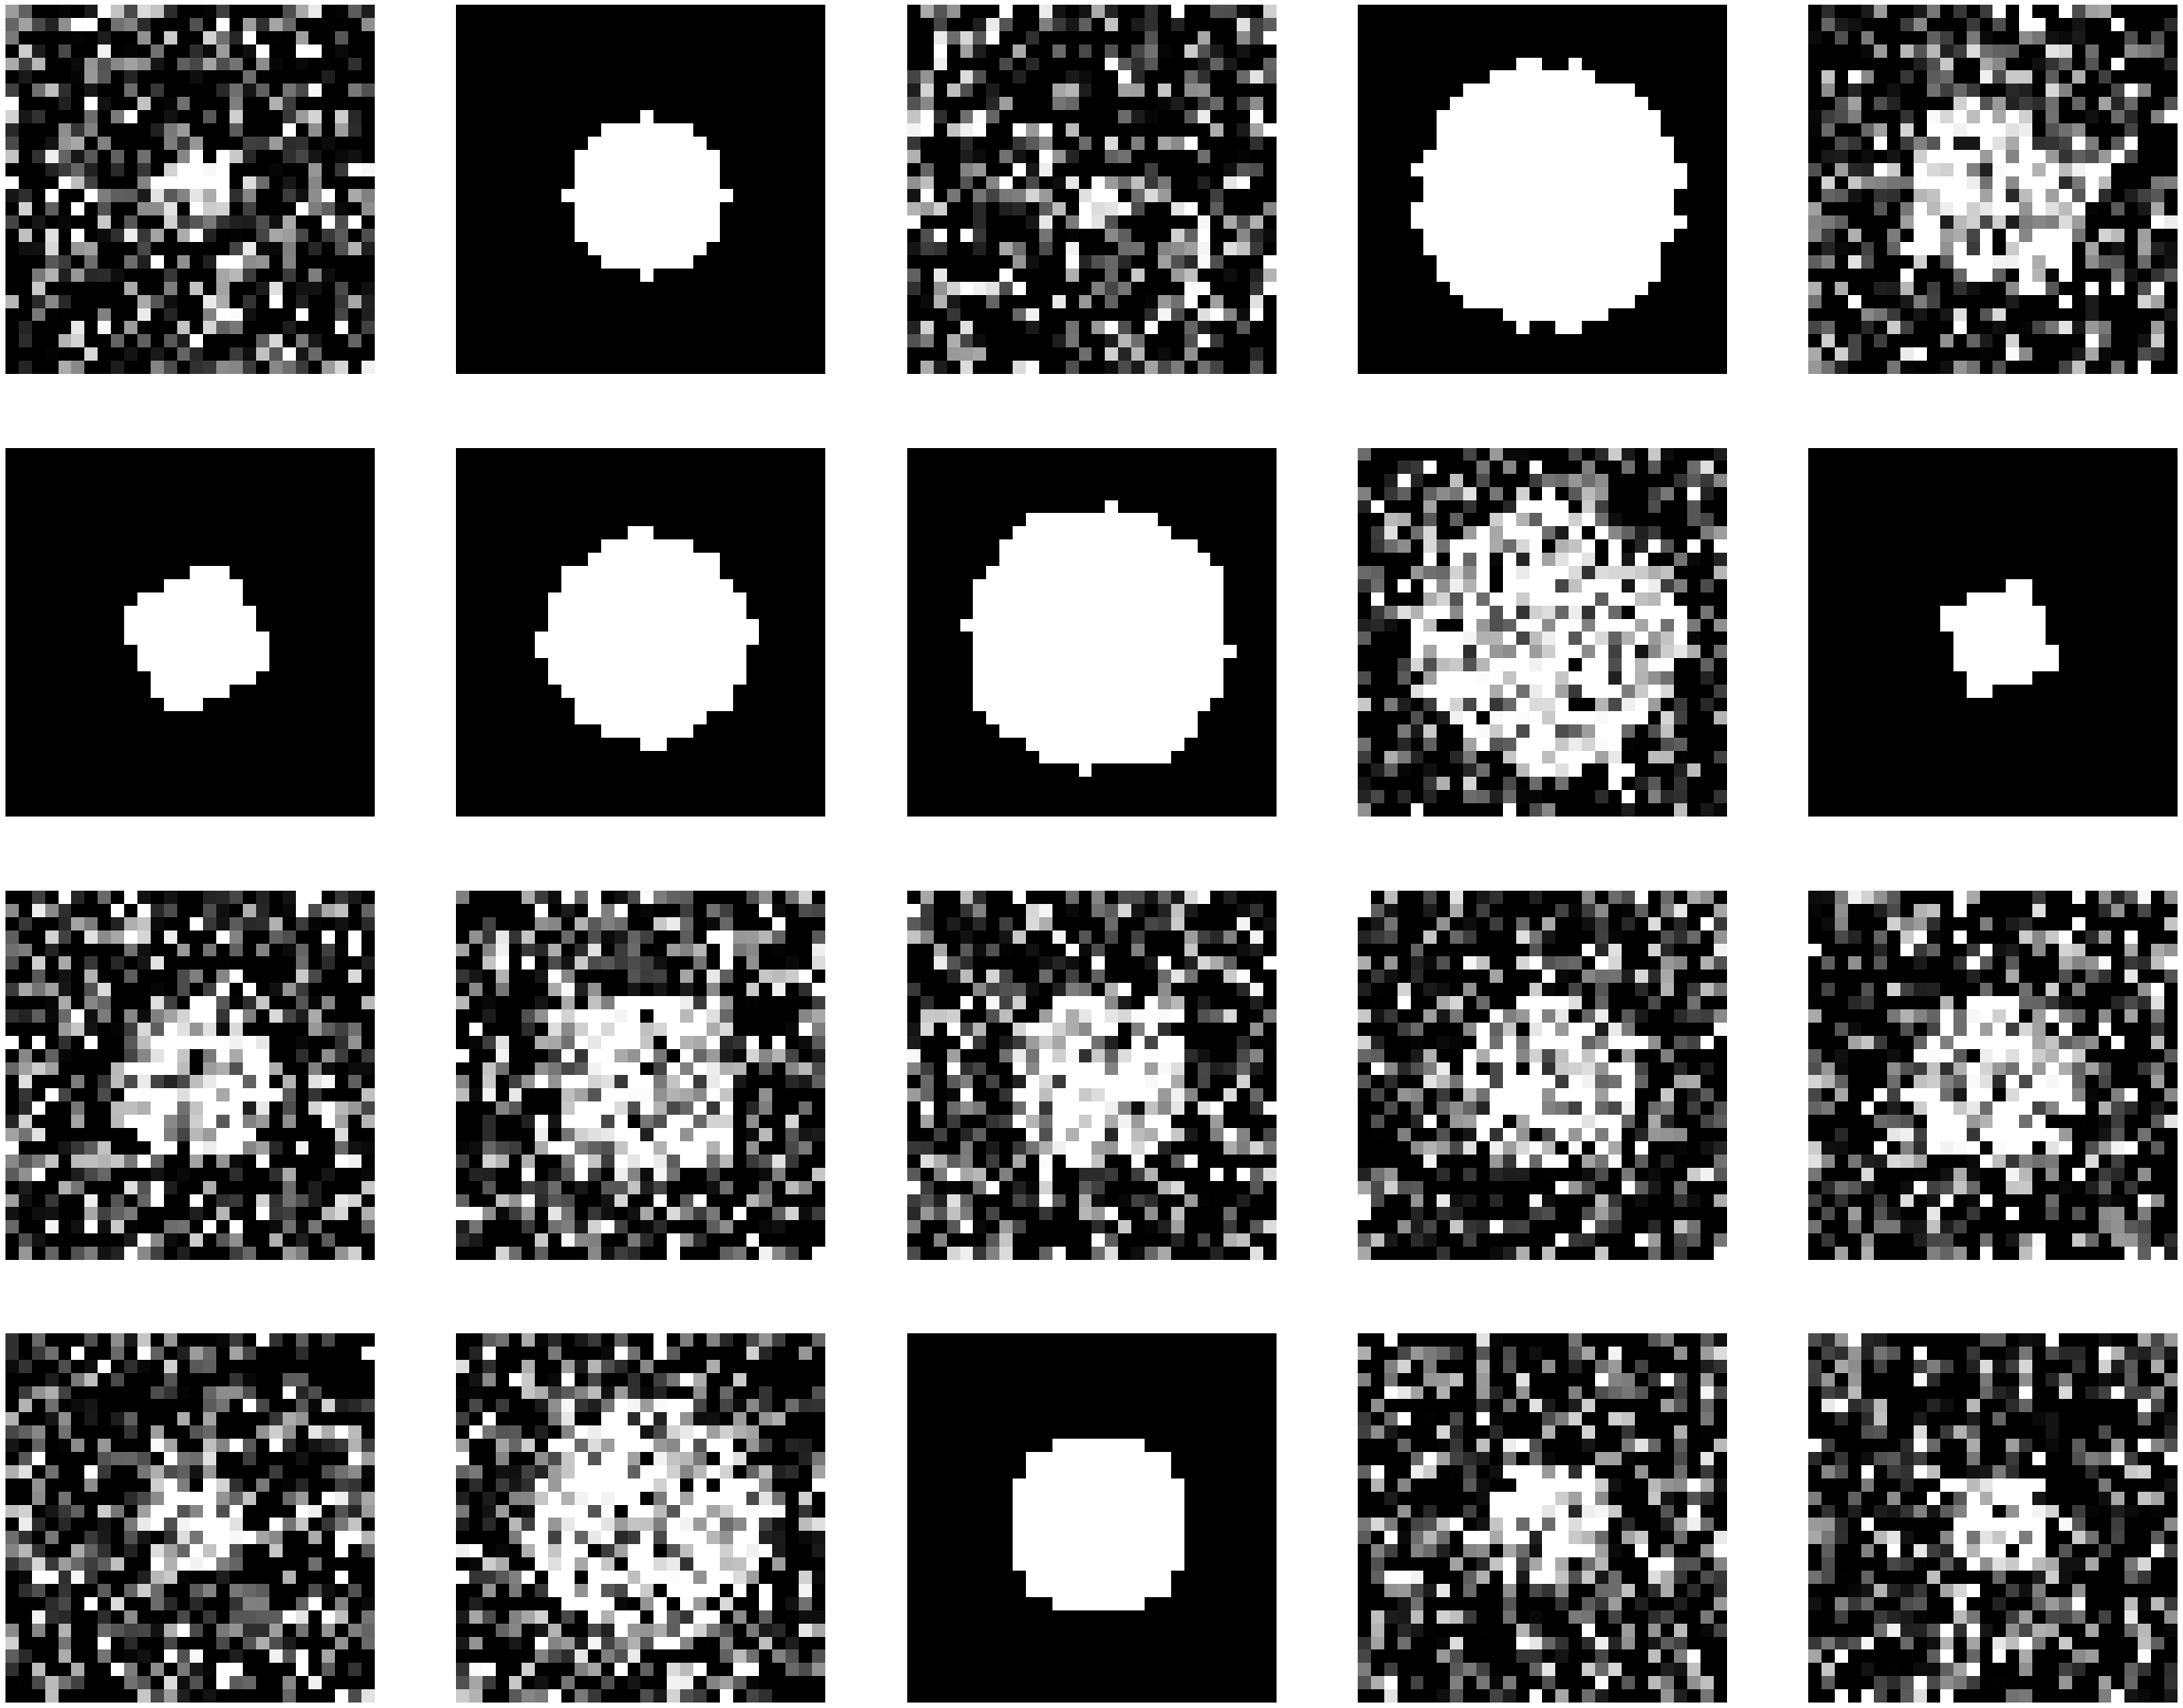

In [3]:
fig, axes = plt.subplots(4, 5, figsize=(50,40))
axes = axes.flatten()
    
for i in range(20):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis('off') 


### Define NN

Let's now define a CNN architecture using `Pytorch`

In [4]:
class cnn_model(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),# 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) 
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=hidden_units*7*7,  
                      out_features=output_shape) # Fully connected layer
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x


torch.manual_seed(42)

model_1 =  cnn_model(input_shape=1, hidden_units= 10, output_shape=2)
model_1

cnn_model(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=2, bias=True)
  )
)

We now define the loss function and the optimizer 

In [5]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

BATCH_SIZE = 50
EPOCHS = 12


## Train test loop model 

We begin by defining the training and test sets using the `generate_dataset` function, followed by creating the corresponding dataloaders.
Finally, we run the training and testing loop using the `tran_test_loop` function from `modular`

In [6]:
# Define data loader
train_dataset, test_dataset = cs.generate_dataset(images, labels)
        
train_dataloader = DataLoader(train_dataset, 
                              batch_size= 32, 
                              shuffle=False)
                             
test_dataloader = DataLoader(test_dataset,
                             batch_size= 32,
                             shuffle=False)
            
result = engine.train_test_loop(model_1,train_dataloader,test_dataloader,
                                optimizer, loss_fn, epochs = EPOCHS,print_b=False)


We will consider these two classification metrics to assess models performance:

1. Accuracy : $\displaystyle AC(y,\hat{y}) = \frac{1}{N}\sum_{i=1}^N I_{y^{(i)} =\max_j\{\hat{y}_j^{(i)}\}}$

2. Cross entropy:  $\displaystyle CE(y,\hat{y}) = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^C y_j^{(i)}\log(\hat{y}_j^{(i)})$

$\hat{y}^{(i)}$: predicted probability vector of observation $i$

$y^{(i)}$: true label of observation $i$

The cross-entropy index incorporates the predicted probability for each class. It increases as the predicted probability diverges from the true label, such that a perfect model would have a cross-entropy value of 0. 

Let's check them

In [8]:
print('Test Accuracy: ',result['test_acc'][EPOCHS-1])

print('Test Cross-Entropy: ',result['test_ce'][EPOCHS-1])


Test Accuracy:  84.29276315789474
Test Cross-Entropy:  5.318332090325911
